### Kernel Density Estimation

In [1]:
from Utilities.utils import read_data

In [2]:
url = 'https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt'
raw, _ = read_data(url)

c:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\ML\GammaRayBursts\Utilities\utils.py:21: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  raw = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


In [3]:
fluence, fluence_err = zip(*[(float(a), float(b)) for a, b in zip(raw[9], raw[10]) 
                                           if a != '-999' and b != '-999' 
                                           and float(b)!=0 and float(a)!=0] )

In [4]:
import numpy as np

In [5]:
erg_to_KeV = 624150907446.1*1e-3

In [6]:
fluence = np.log10(np.array(fluence)*erg_to_KeV)

In [7]:
import matplotlib.pyplot as plt
from Utilities import plot_settings

Text(0, 0.5, 'Density')

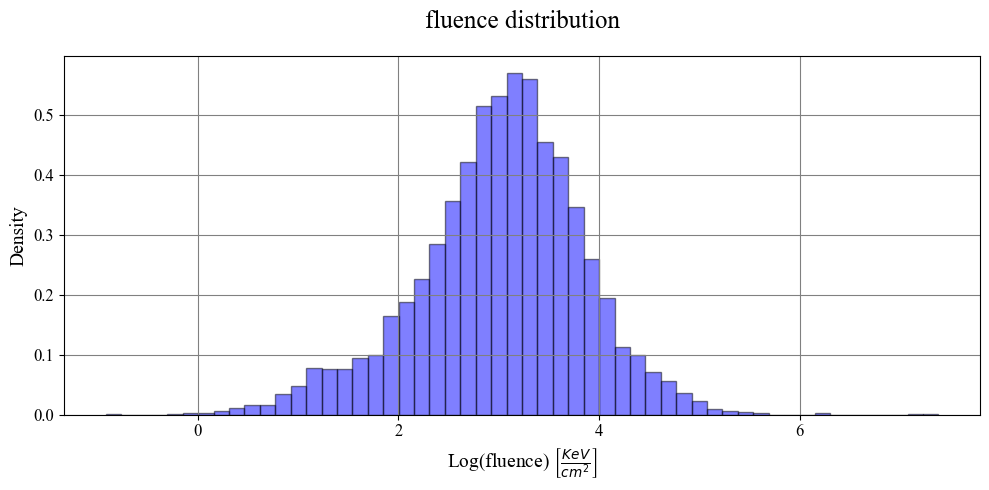

In [8]:
fluencec, fluenceb, _ = plt.hist(fluence, bins='scott', density=True, 
                         histtype='barstacked', edgecolor='black', color='blue', alpha=0.5) 
plt.title('fluence distribution')
plt.xlabel(r'Log(fluence) $\left[\frac{KeV}{cm^2}\right]$')
plt.ylabel('Density')

In [9]:
from sklearn.neighbors import KernelDensity

In [10]:
import numpy as np

In [11]:
X = fluence.reshape((-1,1))

In [12]:
bandwidths = np.linspace(0.1,1,10)

In [13]:
from Utilities.utils import KDE_LOO, cross_validation_LOO

In [15]:
from sklearn.model_selection import train_test_split

In [17]:
X_train ,X_test = train_test_split(X, test_size=0.2, random_state=42)

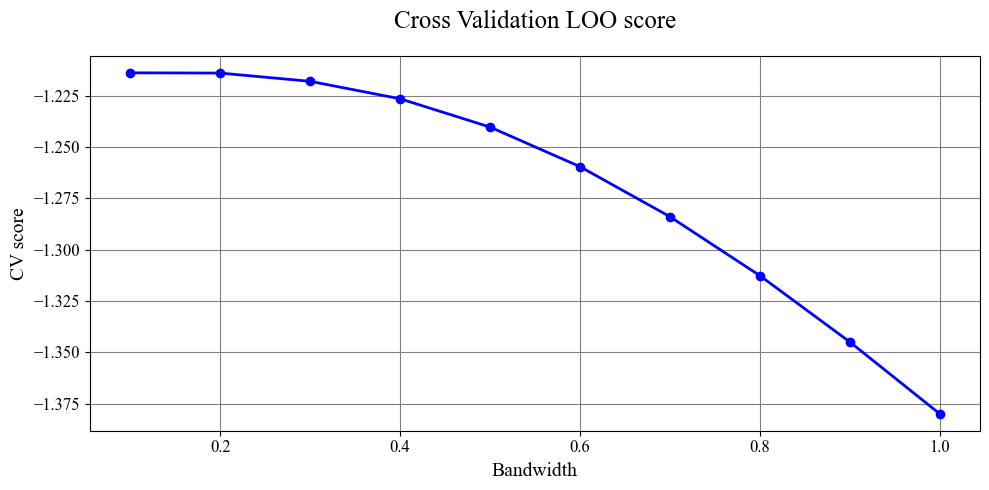

In [18]:
scores, best, best_bw = cross_validation_LOO(X_train, bandwidths, True)

In [19]:
xgrid = np.linspace(np.array(fluence).min(), np.array(fluence).max(),1000)

def kde_sklearn(data, bandwidth, kernel="gaussian"):
    kde_skl = KernelDensity(bandwidth = bandwidth, kernel=kernel)
    kde_skl.fit(data)
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf), kde_skl

In [20]:
X_test.shape

(1323, 1)

In [21]:
pdf, kde = kde_sklearn(X_test, bandwidths[best_bw])

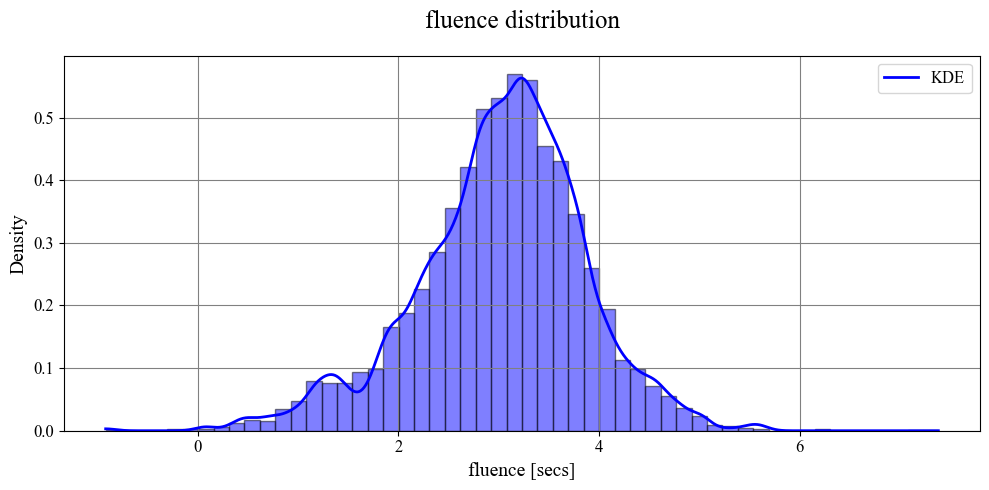

In [22]:
plt.plot(xgrid, pdf, color='blue', linewidth=2, label='KDE')
counts, bins, _ = plt.hist(fluence, bins='scott', density=True, histtype='barstacked', edgecolor='black', color='blue', alpha=0.5) 
plt.title('fluence distribution')
plt.xlabel('fluence [secs]')
plt.ylabel('Density')
plt.legend()

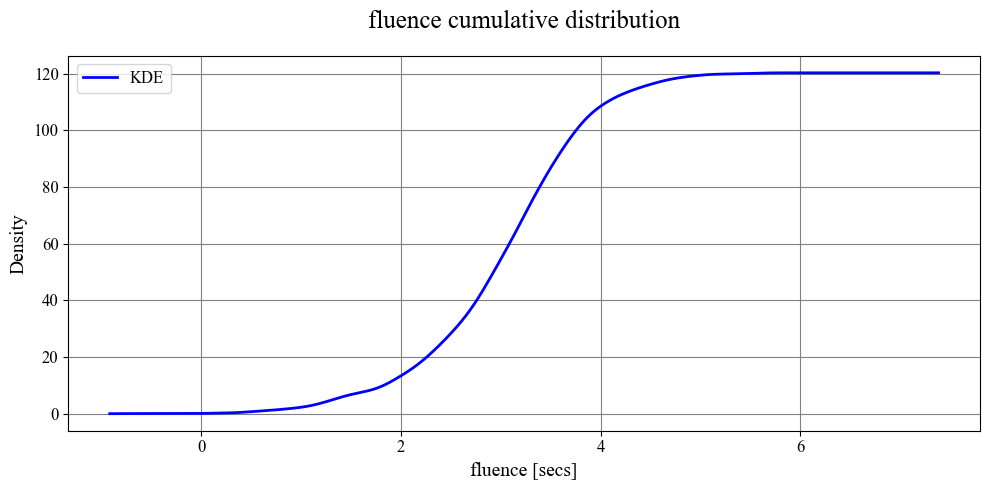

In [23]:
plt.plot(xgrid, np.cumsum(pdf), color='blue', linewidth=2, label='KDE')
plt.title('fluence cumulative distribution')
plt.xlabel('fluence [secs]')
plt.ylabel('Density')
plt.legend()

In [24]:
import scipy.stats

In [30]:
print('fluence Mean: ',10**(fluence.mean()), 'KeV')
print('fluence Std: ', 10**(fluence.std()), 'KeV')
print('fluence mode:', 10**(scipy.stats.mode(fluence).mode), 'KeV')
print('fluence max: ', 10**(fluence.max()), 'KeV')
print('fluence min: ', 10**(fluence.min()), 'KeV')

fluence Mean:  1032.814731039941 KeV
fluence Std:  6.847403859048793 KeV
fluence mode: 162.27923593598604 KeV
fluence max:  24239524.64157674 KeV
fluence min:  0.12056723079136311 KeV


## Gaussian Mixture

In [31]:
from sklearn.mixture import GaussianMixture

In [43]:
ns = np.arange(1,10,1)

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
aic = np.zeros_like(ns)
bic = np.zeros_like(ns)
for n in ns:
    GM = GaussianMixture(n_components=n)
    GM.fit(X_train)
    aic[n-min(ns)] = GM.aic(X_test)
    bic[n-min(ns)] = GM.bic(X_test)

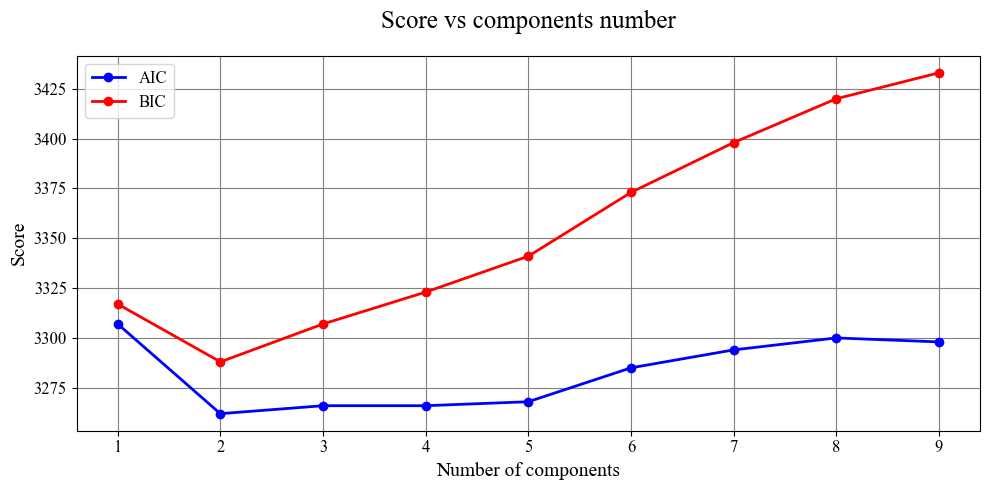

In [46]:
plt.plot(ns, aic, marker='o', color='blue', linewidth=2, label='AIC')
plt.plot(ns, bic, marker='o', color='red', linewidth=2, label='BIC')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.title('Score vs components number')
plt.legend()

In [47]:
GM = GaussianMixture(n_components=2)
GM.fit(X_train)

GaussianMixture(n_components=2)

In [48]:
x = np.linspace(X_test.min() - 0.5, X_test.max() + 0.5, 1000).reshape(-1, 1)

In [49]:
from scipy.stats import norm

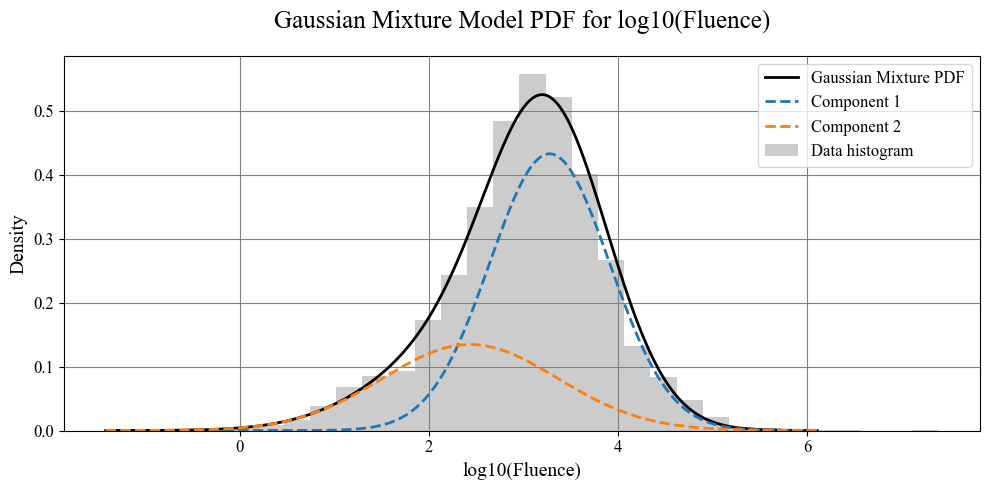

In [50]:
# Compute the weighted sum of PDFs from each Gaussian component
logprob = GM.score_samples(x)
pdf = np.exp(logprob)

# Plot the overall PDF
plt.plot(x, pdf, label='Gaussian Mixture PDF', color='black')

normals = []

# Optionally plot the individual Gaussians
for i in range(GM.n_components):
    mean = GM.means_[i, 0]
    std = np.sqrt(GM.covariances_[i, 0, 0])
    weight = GM.weights_[i]
    component_pdf = weight * norm.pdf(x, mean, std)
    plt.plot(x, component_pdf, '--', label=f'Component {i+1}')
    normals.append(component_pdf)

# Add original data histogram for context
plt.hist(X, bins=30, density=True, alpha=0.4, color='gray', label='Data histogram')

plt.xlabel('log10(Fluence)')
plt.ylabel('Density')
plt.title('Gaussian Mixture Model PDF for log10(Fluence)')
plt.legend()

In [51]:
for i in range(GM.n_components):
    print(f'Fluence Centroid {i}: {np.power(10,GM.means_[i, 0]):.3} +/- {np.sqrt(GM.covariances_[i, 0, 0])*np.power(10,GM.means_[i, 0]):.3} KeV/cm^2')

Fluence Centroid 0: 1.88e+03 +/- 1.19e+03 KeV/cm^2
Fluence Centroid 1: 2.72e+02 +/- 2.52e+02 KeV/cm^2


Compute intersection points (Thresholds)

In [52]:
from scipy.optimize import brentq

In [53]:
pdf1 = lambda x: GM.weights_[0] * norm.pdf(x, GM.means_[0, 0], np.sqrt(GM.covariances_[0, 0, 0]))
pdf2 = lambda x: GM.weights_[1] * norm.pdf(x, GM.means_[1, 0], np.sqrt(GM.covariances_[1, 0, 0]))

In [60]:
diff12 = lambda x: pdf1(x) - pdf2(x)

In [61]:
threshold_12 = brentq(diff12, GM.means_[0, 0], GM.means_[1, 0])

ValueError: f(a) and f(b) must have different signs

In [62]:
print(f'Fluence Threshold: {np.power(10,threshold_12):.3f} KeV/cm^2')

NameError: name 'threshold_12' is not defined